<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/naive_bayes_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Naive Bayes classifiers

We show how to implement Naive Bayes classifiers from scratch.
We use binary features, and 2 classes.
Based on sec 18.9 of http://d2l.ai/chapter_appendix-mathematics-for-deep-learning/naive-bayes.html.




In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import collections
import os
import random

import json
import multiprocessing

import torch
from torch import nn
from torch.nn import functional as F
import torchvision

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

mkdir: cannot create directory ‘figures’: File exists


# Get data

We use a binarized version of MNIST.

In [19]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

mnist_train = torchvision.datasets.MNIST(root='./temp', train=True,
                                         transform=data_transform,
                                         download=True)
mnist_test = torchvision.datasets.MNIST(root='./temp', train=False,
                                        transform=data_transform,
                                        download=True)

In [6]:
print(mnist_train)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./temp
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [9]:
image, label = mnist_train[2]
print(type(image))
print(image.shape)
print(type(label))
print(label)


<class 'torch.Tensor'>
torch.Size([1, 28, 28])
<class 'int'>
4


In [10]:
image[0,15:20,15:20] # not binary (pytorch rescales to 0:1)

tensor([[0.3569, 0.1098, 0.0196, 0.9137, 0.9804],
        [0.0000, 0.0000, 0.4000, 0.9961, 0.8627],
        [0.0000, 0.0000, 0.6627, 0.9961, 0.5373],
        [0.0000, 0.0000, 0.6627, 0.9961, 0.2235],
        [0.0000, 0.0000, 0.6627, 0.9961, 0.2235]])

In [13]:
[torch.min(image), torch.max(image)]


[tensor(0.), tensor(1.)]

In [33]:
print(mnist_train[0][0].shape) # (1,28,28)
indices = [0,1]
xx=torch.stack([mnist_train[i][0] for i in indices])
print(xx.shape)
xx=torch.stack([mnist_train[i][0] for i in indices], dim=1)
print(xx.shape)
xx=torch.stack([mnist_train[i][0] for i in indices], dim=1).squeeze(0)
print(xx.shape)

torch.Size([1, 28, 28])
torch.Size([2, 1, 28, 28])
torch.Size([1, 2, 28, 28])
torch.Size([2, 28, 28])


In [58]:
# convert from torch.tensor to numpy, extract subset of indices, optionally binarize
def get_data(data, indices=None, binarize=True):
  N = len(data)
  if indices is None:
    indices = range(0, N)
  #X = torch.stack([data[i][0] for i in indices], dim=1).squeeze(0) # (N,28,28)
  X = np.stack([data[i][0].numpy() for i in indices], axis=1).squeeze(0) # (N,28,28)
  if binarize: X = (X > 0.5)
  #y = torch.tensor([data[i][1] for i in indices])
  y = np.array([data[i][1] for i in indices])
  return X, y

[(10, 28, 28), (10,)]
[[0.7294118  0.99215686 0.99215686 0.5882353  0.10588235]
 [0.0627451  0.3647059  0.9882353  0.99215686 0.73333335]
 [0.         0.         0.9764706  0.99215686 0.9764706 ]
 [0.50980395 0.7176471  0.99215686 0.99215686 0.8117647 ]
 [0.99215686 0.99215686 0.99215686 0.98039216 0.7137255 ]]


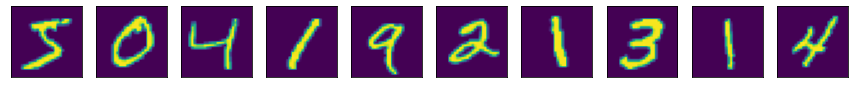

In [59]:
indices = range(0,10)
images, labels = get_data(mnist_train, indices, False)
print([images.shape, labels.shape])
print(images[0,15:20,15:20]) # not binary (pytorch rescales to 0:1)

d2l.show_images(images, 1, 10);

[(10, 28, 28), (10,)]
[[ True  True  True  True False]
 [False False  True  True  True]
 [False False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


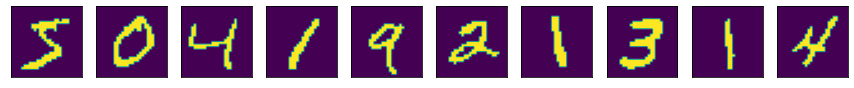

In [60]:
indices = range(0,10)
images, labels = get_data(mnist_train, indices, True)
print([images.shape, labels.shape])
print(images[0,15:20,15:20]) # binary
d2l.show_images(images, 1, 10);

In [61]:
X_train, y_train = get_data(mnist_train)
X_test, y_test = get_data(mnist_test)



In [63]:
print(X_train.shape)
print(type(X_train))

print(X_train[0,15:20,15:20])

(60000, 28, 28)
<class 'numpy.ndarray'>
[[ True  True  True  True False]
 [False False  True  True  True]
 [False False  True  True  True]
 [ True  True  True  True  True]
 [ True  True  True  True  True]]


# Training



In [70]:
n_y = np.zeros(10)
for y in range(10):
    n_y[y] = (y_train == y).sum()
P_y = n_y / n_y.sum()
P_y

array([0.09871667, 0.11236667, 0.0993    , 0.10218333, 0.09736667,
       0.09035   , 0.09863333, 0.10441667, 0.09751667, 0.09915   ])

In [65]:
# Training set is not equally balanced across classes...
print(np.unique(y_train))
from collections import Counter
cnt  = Counter(y_train)
print(cnt.keys())
print(cnt.values())

[0 1 2 3 4 5 6 7 8 9]
dict_keys([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])
dict_values([5421, 5923, 5842, 6742, 5949, 5958, 6131, 5918, 6265, 5851])


We use add-one smoothing for class conditional Bernoulli distributions.

In [86]:
n_x = np.zeros((10, 28, 28))
for y in range(10):
    n_x[y] = (X_train[y_train == y].sum(axis=0))
# using pseudo counts of 1
#P_xy = (n_x + 1) / (n_y + 1).reshape(10, 1, 1)
P_xy = (n_x + 1) / (n_y + 2).reshape(10, 1, 1)
print(P_xy.shape)
print(type(P_xy))


(10, 28, 28)
<class 'numpy.ndarray'>


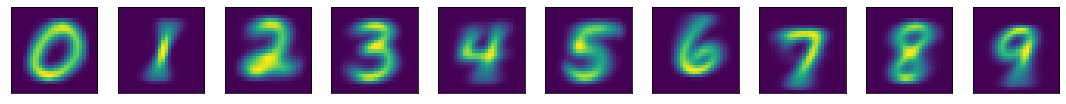

In [93]:
d2l.show_images(P_xy, 1, 10);
plt.tight_layout()
plt.savefig('nbc_mnist_centroids.pdf', dpi=300)

# Testing

In [90]:
log_P_xy = np.log(P_xy)
log_P_xy_neg = np.log(1 - P_xy)
log_P_y = np.log(P_y)

def bayes_pred_stable(x):
    #x = x.unsqueeze(0)  # (28, 28) -> (1, 28, 28)
    x = np.expand_dims(x,0)  # (28, 28) -> (1, 28, 28)
    p_xy = log_P_xy * x + log_P_xy_neg * (1 - x) # select the 0 and 1 pixels
    p_xy = p_xy.reshape(10, -1).sum(axis=1)  # p(x|y)
    return p_xy + log_P_y

def predict(X):
    return [np.argmax(bayes_pred_stable(x)) for x in X]

#image, label = mnist_test[0]
image = X_test[0]
label = y_test[0]
py = bayes_pred_stable(image)
print(py)
print('ytrue ', label, 'yhat ', np.argmax(py))
print(predict([image]))

[-268.97252516 -301.70441241 -245.19514063 -218.87383792 -193.45703309
 -206.09087174 -292.52263925 -114.62566181 -220.33134563 -163.17842631]
ytrue  7 yhat  7
[7]


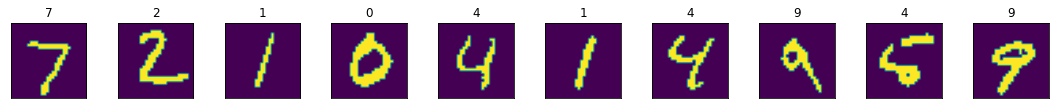

In [94]:
indices = range(0,10)
X1, y1 = get_data(mnist_test, indices, True)
preds = predict(X1)
d2l.show_images(X1, 1, 10, titles=[str(d) for d in preds]);
plt.tight_layout()
plt.savefig('nbc_mnist_preds.pdf', dpi=300)

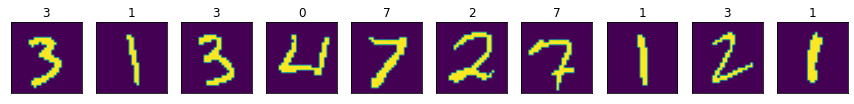

In [84]:
indices = range(30,40)
X1, y1 = get_data(mnist_test, indices, True)
preds = predict(X1)
d2l.show_images(X1, 1, 10, titles=[str(d) for d in preds]);

In [92]:
preds = predict(X_test)
float((preds == y_test).sum()) / len(y_test)  # test accuracy

0.8427